In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        count += 1
        if count >= 3:
            break;
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg


In [2]:
import os 
from pathlib import Path
import shutil
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image  

import spacy  

import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

### split data

In [3]:
src_images_path = "/kaggle/input/flickr8k/Images"
src_captions_path = "/kaggle/input/flickr8k/captions.txt"

images_ls = os.listdir(src_images_path)

def splitter_fn(data,train_size=100, valid_size=0, test_size=0):
    test_len = round(len(data) * (test_size/100))
    train_len = len(data) - test_len
    valid_len = round(len(data) * valid_size/100)
    train_len -= valid_len
    
    train_set = data[0:train_len]
    valid_set = data[train_len:train_len + valid_len]
    test_set = data[train_len + valid_len:train_len + valid_len + test_len]
    
    return train_set,valid_set,test_set
    
    
train_set,valid_set,test_set = splitter_fn(images_ls, 60,0,40)  


### Get Loader

In [4]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 9.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/lib/python3.7/site-packages/en_core_web_sm -->
/opt/conda/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [5]:
spacy_eng = spacy.load("en_core_web_sm")

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"} 
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list): # e.g: sentence_list = ['caption1', "caption2",...]
        frequencies = {}
        idx = 4 # key to add to self.itos. Note that it contains yet 3 keys index

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1
                else:
                    frequencies[word] += 1

                # if this frequencies of this word reaches freq_threshold
                if frequencies[word] == self.freq_threshold: 
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)
        
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

    
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, list_images, transform=None, freq_threshold=1):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        flags  = self.df["image"].isin(list_images) 
        self.df = self.df[flags]
        self.df.reset_index(drop=True, inplace=True)
        
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]       
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist()) 
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        
        #Load image with PIL
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB") 
        if self.transform is not None:
            img = self.transform(img)
   
        numericalized_caption = [self.vocab.stoi["<SOS>"]] 
        numericalized_caption += self.vocab.numericalize(caption)           
        numericalized_caption.append(self.vocab.stoi["<EOS>"]) # e.g: numericalized_caption = [1, 3, 3, 3, 2,...]
        
        return img, torch.tensor(numericalized_caption) 

    
class MyCollate: 
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx
        
    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch] 
        imgs = torch.cat(imgs, dim=0) 
           
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)
        return imgs, targets

def get_loader(root_folder,
                annotation_file,
                images_list,
                transform,
                batch_size=32,
                num_workers=8,
                shuffle=True,
                pin_memory=True):
    dataset = FlickrDataset(root_folder, annotation_file, images_list, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        num_workers=num_workers,
                        shuffle=shuffle,
                        pin_memory=pin_memory,
                        collate_fn=MyCollate(pad_idx=pad_idx))

    return loader, dataset

### Model

In [6]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size, train_CNN=False):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.times = []
        self.dropout = nn.Dropout(p=0.5) 

    def forward(self, images):
        features = self.inception(images)
        output = self.relu(features)       
        return self.dropout(output)


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)        
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class CNNtoRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNNtoRNN, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoderCNN(images)
        outputs = self.decoderRNN(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []

        with torch.no_grad():
            x = self.encoderCNN(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoderRNN.lstm(x, states)              
                output = self.decoderRNN.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoderRNN.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


### utilities

In [7]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step


def test_some_examples(model, device, vocab, images_path, captions_path, images_ls_to_filter):
    transform = transforms.Compose([transforms.Resize((299, 299)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    model.eval()
    
    random.shuffle(images_ls_to_filter)
    list_images = images_ls_to_filter[0:10]
    
    captions_lines = open(captions_path, 'r').readlines()
    
    selected_captions = []
    for image_name in list_images:
        for caption in captions_lines:
            if image_name in caption:
                selected_caption = caption.split(',')[1]
                selected_captions.append(selected_caption)
                break;
    
    for i,image_name in enumerate(list_images):
        test_image =  os.path.join(images_path, image_name)
        plt.figure(figsize=(3,3))
        img = mpimg.imread(test_image)
        imgplot = plt.imshow(img)
        plt.show()
        test_image = transform(Image.open(test_image).convert("RGB")).unsqueeze(0)
        print(f'Annotation cible: {selected_captions[i]}')
        print(f'Annotation prediction: {model.caption_image(test_image.to(device), vocab)}\n\n')   
    
    model.train()

    
    
def train(train_set, num_epochs):
    transform = transforms.Compose([transforms.Resize((356, 356)),
                                    transforms.RandomCrop((299, 299)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
 
    train_loader, dataset = get_loader(root_folder=src_images_path,
                                       annotation_file=src_captions_path,
                                       images_list=train_set,
                                       transform=transform,
                                       batch_size=32,
                                       num_workers=8)

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    load_model = False
    save_model = True
    train_CNN = True

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = num_epochs

    step = 0

    # initialize model, loss etc
    model = CNNtoRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.encoderCNN.inception.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load("./my_checkpoint.pth.tar"), model, optimizer)

    model.train()

    train_losses = []
    for epoch in range(num_epochs):
        print('Epoch', epoch, ' in progress...')          
        losses = []
        for idx, (imgs, captions) in enumerate(train_loader):
            imgs = imgs.to(device)
            captions = captions.to(device)

            outputs = model(imgs, captions[:-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))

            losses.append(loss.item())         

            step += 1

            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()
            
        train_losses.append(sum(losses)/len(losses))
        print(f'Epoch {epoch} - Train loss: {sum(losses)/len(losses):.4f}')
        
    if save_model:
            checkpoint = {"state_dict": model.state_dict(),
                          "optimizer": optimizer.state_dict(),
                          "step": step}
            save_checkpoint(checkpoint)
        
    return model, device, dataset, train_losses

### Train

In [8]:
model, device, dataset, train_losses = train(train_set, num_epochs=80)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

Epoch 0  in progress...
Epoch 0 - Train loss: 4.3118
Epoch 1  in progress...
Epoch 1 - Train loss: 3.5567
Epoch 2  in progress...
Epoch 2 - Train loss: 3.3504
Epoch 3  in progress...
Epoch 3 - Train loss: 3.2165
Epoch 4  in progress...
Epoch 4 - Train loss: 3.1135
Epoch 5  in progress...
Epoch 5 - Train loss: 3.0251
Epoch 6  in progress...
Epoch 6 - Train loss: 2.9482
Epoch 7  in progress...
Epoch 7 - Train loss: 2.8811
Epoch 8  in progress...
Epoch 8 - Train loss: 2.8243
Epoch 9  in progress...
Epoch 9 - Train loss: 2.7703
Epoch 10  in progress...
Epoch 10 - Train loss: 2.7229
Epoch 11  in progress...
Epoch 11 - Train loss: 2.6803
Epoch 12  in progress...
Epoch 12 - Train loss: 2.6396
Epoch 13  in progress...
Epoch 13 - Train loss: 2.6035
Epoch 14  in progress...
Epoch 14 - Train loss: 2.5664
Epoch 15  in progress...
Epoch 15 - Train loss: 2.5341
Epoch 16  in progress...
Epoch 16 - Train loss: 2.5026
Epoch 17  in progress...
Epoch 17 - Train loss: 2.4729
Epoch 18  in progress...
Epoch

### Test

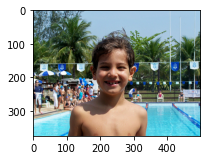

Annotation cible: A boy is smiling whilst standing in front of a swimming pool .

Annotation prediction: ['<SOS>', 'a', 'young', 'boy', 'wearing', 'a', 'blue', 'shirt', 'is', 'walking', 'on', 'a', 'beach', '.', '<EOS>']




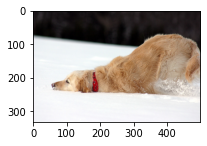

Annotation cible: A brown dog has his face down in the snow .

Annotation prediction: ['<SOS>', 'a', 'dog', 'runs', 'through', 'the', 'snow', '.', '<EOS>']




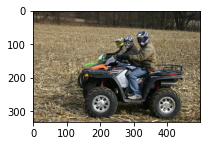

Annotation cible: Three people drive ATVs .

Annotation prediction: ['<SOS>', 'three', 'people', 'are', 'riding', 'a', 'blue', 'atv', '.', '<EOS>']




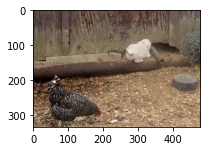

Annotation cible: A chicken and a white dog in the mulch .

Annotation prediction: ['<SOS>', 'a', 'dog', 'is', 'running', 'through', 'the', 'water', '.', '<EOS>']




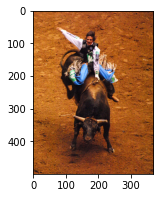

Annotation cible: "A bull rider hangs on tightly to a rope around a large 
Annotation prediction: ['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'riding', 'a', 'bike', 'on', 'a', 'dirt', 'path', '.', '<EOS>']




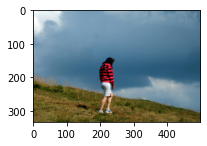

Annotation cible: A person in a red striped hooded sweatshirt and jeans shorts walking on a grassy hill .

Annotation prediction: ['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'climbing', 'a', 'rock', 'wall', '.', '<EOS>']




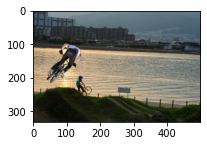

Annotation cible: A man is in the air with his bike and there 's another guy on his bike in the back with the water close by .

Annotation prediction: ['<SOS>', 'a', 'man', 'on', 'a', 'motorcycle', 'is', 'turning', 'a', 'dirt', 'bike', '.', '<EOS>']




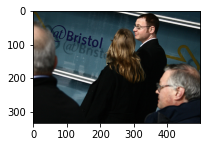

Annotation cible: A group of adults are walking .

Annotation prediction: ['<SOS>', 'a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'couch', '.', '<EOS>']




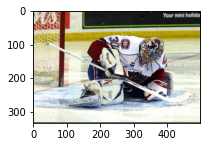

Annotation cible: A goalie blocks the puck while holding a white hockey stick .

Annotation prediction: ['<SOS>', 'a', 'hockey', 'player', 'in', 'red', 'untangles', 'from', 'a', 'goal', '.', '<EOS>']




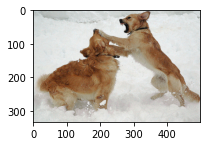

Annotation cible: A brown and white dog bares his teeth and grabs the head of another brown and white dog .

Annotation prediction: ['<SOS>', 'two', 'dogs', 'are', 'playing', 'in', 'the', 'snow', '.', '<EOS>']




In [9]:
test_some_examples(model, 
                   device, 
                   dataset.vocab, 
                   src_images_path, 
                   src_captions_path,
                   train_set)

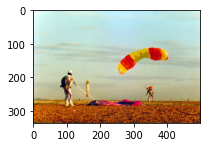

Annotation cible: A skydiver safely lands while another watches from the ground .

Annotation prediction: ['<SOS>', 'a', 'man', 'is', 'standing', 'on', 'a', 'rock', 'overlooking', 'a', 'lake', '.', '<EOS>']




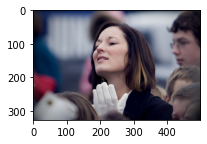

Annotation cible: A lady stands in the middle of a crowd wearing white gloves .

Annotation prediction: ['<SOS>', 'a', 'woman', 'in', 'a', 'blue', 'shirt', 'is', 'sitting', 'on', 'a', 'wooden', 'bench', '.', '<EOS>']




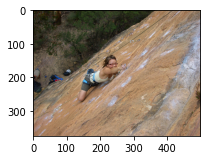

Annotation cible: A girl wearing glasses is in a blue harness while rock climbing .

Annotation prediction: ['<SOS>', 'a', 'man', 'in', 'a', 'red', 'jacket', 'is', 'standing', 'on', 'a', 'rock', 'overlooking', 'a', 'valley', '.', '<EOS>']




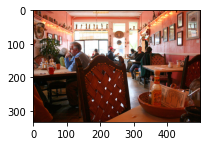

Annotation cible: An empty seat at a Mexican themed restaurant .

Annotation prediction: ['<SOS>', 'a', 'group', 'of', 'people', 'are', 'standing', 'around', 'a', 'sound', 'mixing', 'table', '.', '<EOS>']




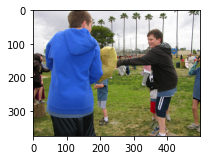

Annotation cible: A boy in a black shirt punches a yellow punching bag while a boy in a blue sweatshirt holds the bag .

Annotation prediction: ['<SOS>', 'a', 'woman', 'in', 'a', 'white', 'dress', 'walks', 'with', 'a', 'man', 'in', 'a', 'black', 'jacket', '.', '<EOS>']




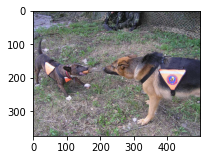

Annotation cible: A small black dog is playing tug of war with a large brown dog wearing a yellow triangle .

Annotation prediction: ['<SOS>', 'two', 'dogs', 'are', 'playing', 'in', 'a', 'field', '.', '<EOS>']




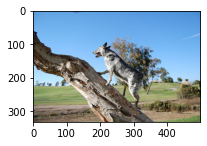

Annotation cible: A black and white dog climbs a leaning tree trunk .

Annotation prediction: ['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'snowboarding', '.', '<EOS>']




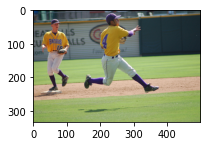

Annotation cible: Men play baseball .

Annotation prediction: ['<SOS>', 'two', 'men', 'playing', 'soccer', '.', '<EOS>']




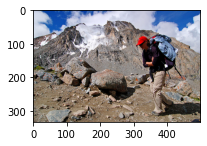

Annotation cible: A backpacker is walking in front of a mountain with arms crossed .

Annotation prediction: ['<SOS>', 'a', 'man', 'is', 'riding', 'a', 'mountain', 'bike', 'on', 'a', 'dirt', 'path', '.', '<EOS>']




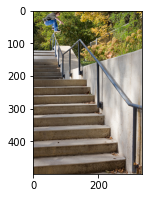

Annotation cible: A kid skateboards down railings of a large set of stairs .

Annotation prediction: ['<SOS>', 'a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'doing', 'a', 'trick', 'on', 'a', 'skateboard', '.', '<EOS>']




In [10]:
test_some_examples(model, 
                   device, 
                   dataset.vocab, 
                   src_images_path, 
                   src_captions_path,
                   test_set)

### Plot Section

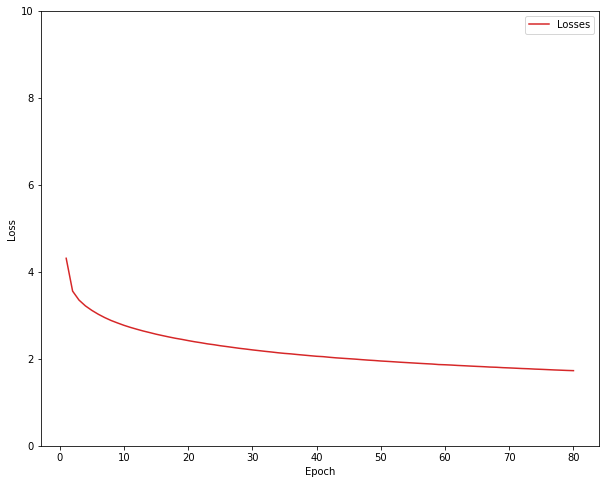

In [11]:
num_epochs = 80

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

axs.plot(np.arange(1, num_epochs+1), np.asarray(train_losses), label='Losses', color='tab:red')
axs.set_xlabel('Epoch')
axs.set_ylabel('Loss') 
axs.set_ylim(0, 10)
axs.legend()

plt.savefig("loss.png")